# Vetorização de Imagens ( Image Tracing)


### 1. Banco de imagens

Começar por formas simples pra testar e depois vamos complicando,
alguns exemplos que acho que dariam certo :

In [13]:
import numpy as np
np.set_printoptions(threshold=100000)   #permite printar todo o array
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image


import skimage.morphology as mm
from skimage.segmentation import watershed, join_segmentations
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries

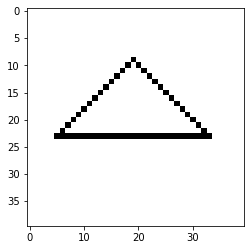

In [14]:
# Abre a imagem exemplo
# desenhei no gimp uma linha numa imagem 40x40 pra ficar simples

line = Image.open('empty_triangle.png').convert('L')
img = np.array(line)
plt.imshow(img, cmap='gray')

### 2. Segmentação
Revisar os algoritmos que usamos e ver qual se adequa melhor ao nosso objetivo

*estou testando watershed*

Text(0.5, 1.0, 'Imagem segmentada - linha de watershed')

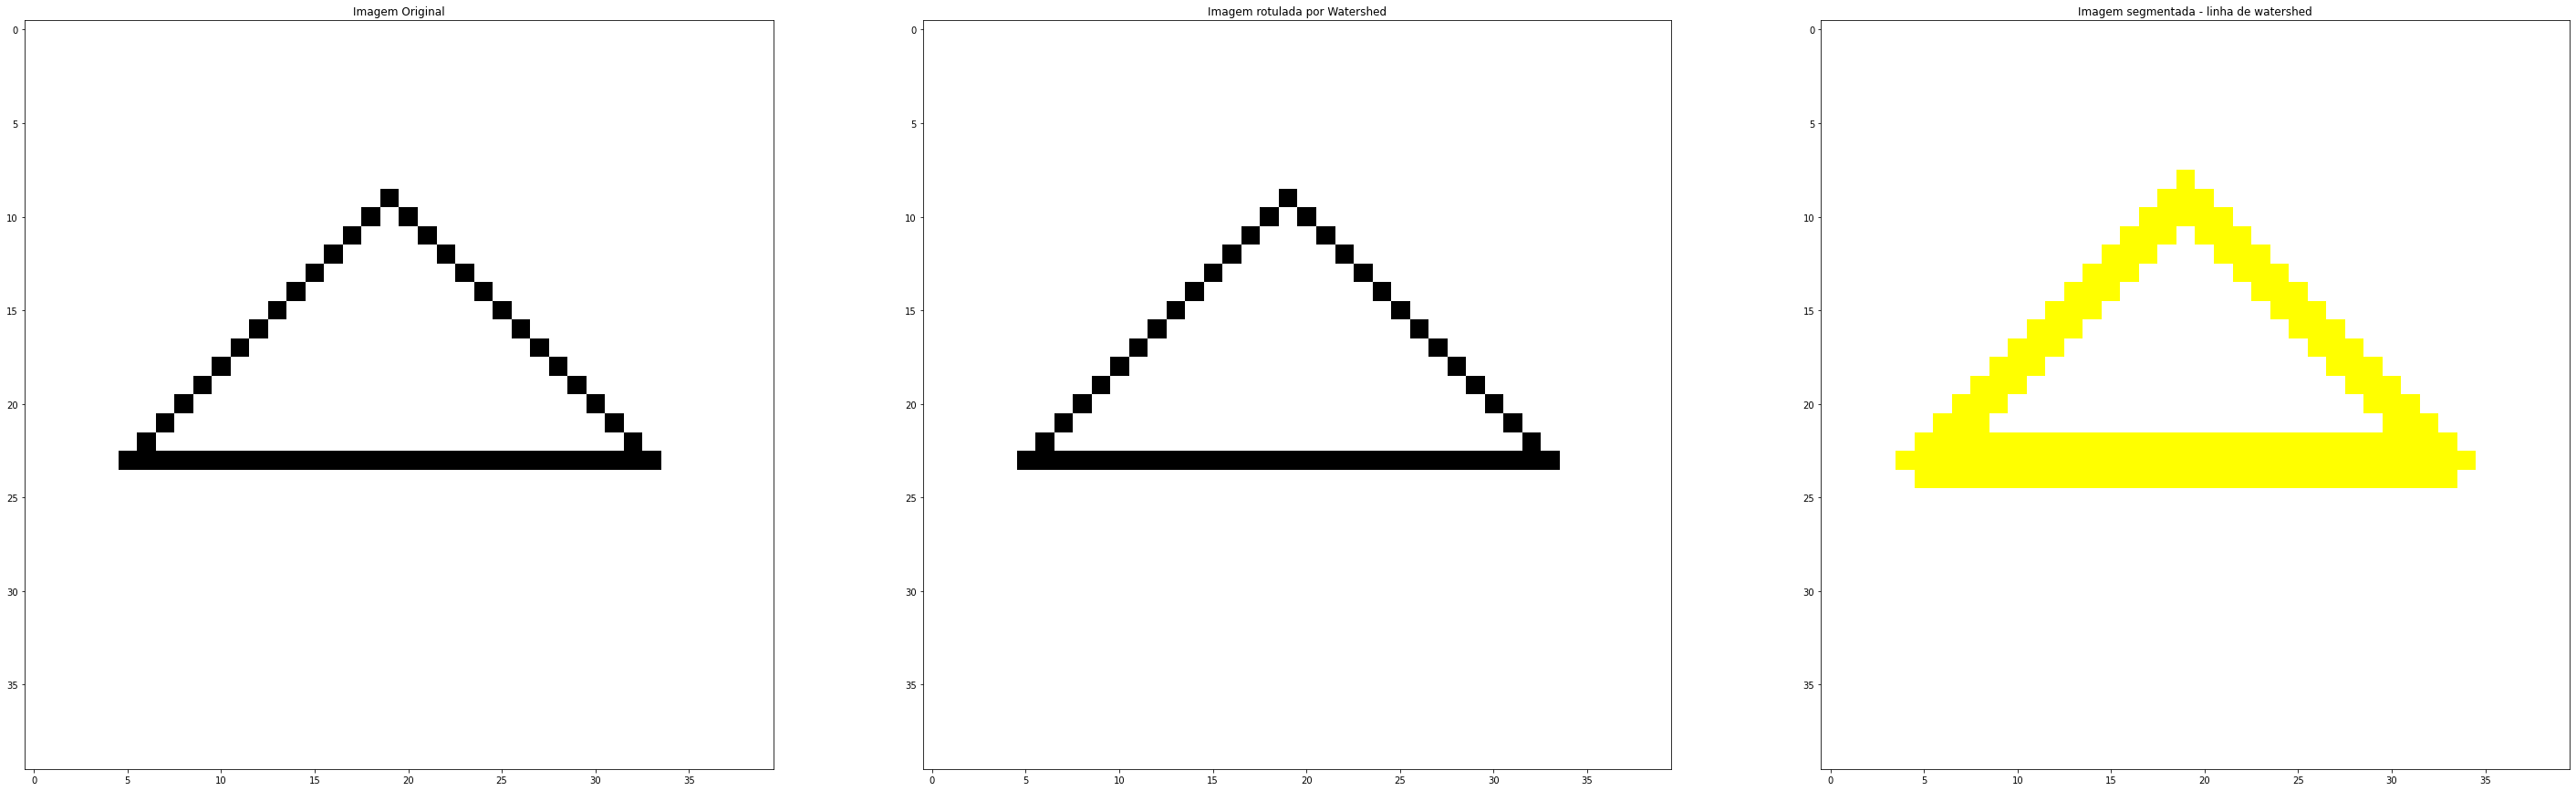

In [15]:
markers = np.zeros_like(img)
foreground, background = 1, 2 # rótulos para as sementes (objeto = 1 e fundo = 2)
markers[img > 180] = background 
markers[img < 100] = foreground

# Cálculo do watershed a partir da imagem e dos marcadores
w1 = watershed(img, markers)
plt.figure(1, figsize=(50,30))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.subplot(1,3,2)
plt.imshow(w1, cmap='gray')
plt.title('Imagem rotulada por Watershed')
plt.subplot(1,3,3)
plt.imshow(mark_boundaries(img,w1))
plt.title('Imagem segmentada - linha de watershed')

### 3. Algoritmo para detecção das formas básicas (retas/curvas)


* Detectar pontos de conexão (cantos) e descontinuidades nas formas


* Utilizar uma função de Fit para gerar as equações (podemos começar só com retas e equações de segundo grau) da reta/curva que interliga cada segmento 
entre 2 pontos



* Calcular o erro gerado por cada aproximação e escolher o menor
 	exemplo  P1 (35, 12)  ->    6.4x² - 2.65x + 0.12 	 ->   P2(52, 46)  
    
    
    
* Armazenar numa estrutura de dados os pontos e equações 




In [16]:
# em w1, imagem com o watershed ja:
# 1 = branco
# 2 = preto


# dependendo de qual tipo de curva vc quer basta chamar uma das quatro


def check_for_anormalities(segmentoX): # checa se há uma anomalia, ou seja, se há pontos alinhados que não são bem tratrados pelo fit
        for i in range(0, segmentoX.size):
            if segmentoX[i] != segmentoX[i - 1]:
                return 0
        return 1
                
def checa_limite(x, y, segmentoX, segmentoY):
    # checar se existem pelo menos 3 pontos no vetor pra poder fazer a checagem
    if(segmentoX.size >= 3):
        f = np.polyfit(segmentoX, segmentoY, 1)
        f = np.poly1d(f)
        
        line = check_for_anormalities(segmentoX)
        if line == 1: # se todos os pontos estão alinhados pode inserir
            return 1
        else:
            error = np.power(y - f(x),2)
            if(error > 50):
                return 0 # se o erro for maior que o threshold, retorna 0 e não permite que a inserção seja feita
            else: 
                return 1
    else:
        return 1

def busca(x, y, w1, segmentoX, segmentoY, quadrante):
    found_pixel = 0     
    if (w1[x,y] != 2 and checa_limite(x, y, segmentoX, segmentoY) and not checa_ja_inserido(segmento1x, segmento1y, x, y)): # pixel diretamente à direita em cima
        #print(segmento1x, segmento1y)
        #print(x,y,"\n")
        
        segmentoX = np.append(segmentoX,x)
        segmentoY = np.append(segmentoY,y)
        found_pixel = 1
        
        if(quadrante == 1):
            segmentoX,segmentoY = busca_primeiro_quadrante(x,y,w1,segmentoX,segmentoY)
        elif(quadrante == 2):
            segmentoX, segmentoY = busca_segundo_quadrante(x, y, w1, segmentoX, segmentoY)
        elif(quadrante == 3):
            segmentoX, segmentoY = busca_terceiro_quadrante(x, y, w1, segmentoX, segmentoY)
        else:
            segmentoX, segmentoY = busca_quarto_quadrante(x, y, w1, segmentoX, segmentoY)
             
    return segmentoX, segmentoY, found_pixel


def busca_primeiro_quadrante(x,y,w1,segmentoX,segmentoY): 
    segmentoXTemp = segmentoX
    segmentoYTemp = segmentoY
    ultimo = segmentoXTemp.shape[0] - 1
    
    segmentoX, segmentoY,f_p = busca(x - 1, y, w1, segmentoX, segmentoY, 1)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x - 1, y + 1, w1, segmentoX, segmentoY, 1)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x , y + 1, w1, segmentoX, segmentoY, 1)
    return segmentoX,segmentoY

def busca_segundo_quadrante(x,y,w1,segmentoX,segmentoY): 
    segmentoX, segmentoY,f_p = busca(x, y - 1, w1, segmentoX, segmentoY, 2)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x - 1, y - 1, w1, segmentoX, segmentoY, 2)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x - 1, y , w1, segmentoX, segmentoY, 2)
    return segmentoX,segmentoY

def busca_terceiro_quadrante(x,y,w1,segmentoX, segmentoY):
    segmentoX, segmentoY,f_p = busca(x + 1, y, w1, segmentoX, segmentoY, 3)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x + 1, y - 1, w1, segmentoX, segmentoY, 3)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x , y - 1, w1, segmentoX, segmentoY, 3)
    return segmentoX,segmentoY

def busca_quarto_quadrante(x,y,w1,segmentoX, segmentoY):
    segmentoX, segmentoY,f_p = busca(x, y + 1, w1, segmentoX, segmentoY, 4)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x + 1, y + 1, w1, segmentoX, segmentoY, 4)
    if(f_p != 1):
        segmentoX, segmentoY,f_p = busca(x + 1 , y , w1, segmentoX, segmentoY, 4)

    return segmentoX,segmentoY

#### Função para buscar o primeiro ponto

In [17]:
#achar as bordas de um segmento 1ª borda
for t in range(0, img.shape[0]): # varre em x
    for s in range(0, img.shape[0]): # varre em y
        if(w1[t,s] != 2): # achou o primeiro pixel da borda
            #print(t,s)
            segmento1x = np.array([t])
            segmento1y = np.array([s])
            break
            
    if(w1[t,s] != 2):
            break

### Checa se o pixel já foi inserido

In [127]:
def checa_ja_inserido(segmento1x, segmento1y ,x, y): 
    # usei os segmentos 1 e 2 de forma manual nos parâmetros mas quando definirmos a estrutura a ser utilizada
    # de forma definitiva, trocamos pra generalizar tudo
    for i in range(0, segmento1x.shape[0]-1):
        if(segmento1x[i] == x and segmento1y[i] == y):
            return 1
    # se o ponto já tiver sido inserido nesse ponto já retornou um 1, se não retorna 0 e sabemos que n pegamos o ponto ate agora
    return 0
    

#### Algoritmo para buscar os segmentos

In [130]:
# Sempre começamos checando do primeiro - quarto - terceiro - segundo quadrantes, seguindo o sentido horário

# Este bloco busca no sentido horário os pixels ao redor de um pixel, se checou o primeiro 1/4 e não achou, passa para o próximo 
# e por ai vai, até achar algo, não considearndo pontos perdidos, ou seja, um ponto sozinho no meio da imagem
segmento1x, segmento1y = busca_primeiro_quadrante(t, s, w1, segmento1x, segmento1y)
last_quadrant = 1
if(segmento1x.shape[0] == 1):
    last_quadrant = 4
    segmento1x, segmento1y = busca_quarto_quadrante(t, s, w1, segmento1x, segmento1y)
    if(segmento1x.shape[0] == 1):
        last_quadrant = 3
        segmento1x, segmento1y = busca_terceiro_quadrante(t, s, w1, segmento1x, segmento1y)
        if(segmento1x.shape[0] == 1):       
            segmento1x, segmento1y = busca_segundo_quadrante(t, s, w1, segmento1x, segmento1y)
            last_quadrant = 2
# pega o último píxel utilizado para começar o próximo segmento
last_pixel = (segmento1x[segmento1x.shape[0] - 1], segmento1y[segmento1x.shape[0] - 1])
segmento2x = np.array([last_pixel[0]])
segmento2y = np.array([last_pixel[1]])

# utilizando last quadrant podemos saber qual foi o quadrante de que viemos, evitando voltarmos no segmento
if(last_quadrant != 1):    
    segmento2x, segmento2y = busca_primeiro_quadrante(last_pixel[0], last_pixel[1], w1, segmento2x, segmento2y)
    last_quadrant = 1
if(segmento2x.shape[0] == 1 and last_quadrant != 4):
    last_quadrant = 4
    segmento2x, segmento2y = busca_quarto_quadrante(last_pixel[0], last_pixel[1], w1, segmento2x, segmento2y)
if(segmento2x.shape[0] == 1 and last_quadrant != 3):
    last_quadrant = 3
    segmento2x, segmento2y = busca_terceiro_quadrante(last_pixel[0], last_pixel[1], w1, segmento2x, segmento2y)
if(segmento2x.shape[0] == 1 and last_quadrant != 2):
    segmento2x, segmento2y = busca_segundo_quadrante(last_pixel[0], last_pixel[1], w1, segmento2x, segmento2y)
    last_quadrant = 2


# pega o último píxel utilizado para começar o próximo segmento
last_pixel = (segmento2x[segmento2x.shape[0] - 1], segmento2y[segmento2x.shape[0] - 1])
segmento3x = np.array([last_pixel[0]])
segmento3y = np.array([last_pixel[1]])
# utilizando last quadrant podemos saber qual foi o quadrante de que viemos, evitando voltarmos no segmento
if(last_quadrant != 1):    
    segmento3x, segmento3y = busca_primeiro_quadrante(last_pixel[0], last_pixel[1], w1, segmento3x, segmento3y)
    last_quadrant = 1
if(segmento3x.shape[0] == 1 and last_quadrant != 4):
    last_quadrant = 4
    segmento3x, segmento3y = busca_quarto_quadrante(last_pixel[0], last_pixel[1], w1, segmento3x, segmento3y)
if(segmento3x.shape[0] == 1 and last_quadrant != 3):
    last_quadrant = 3
    segmento3x, segmento3y = busca_terceiro_quadrante(last_pixel[0], last_pixel[1], w1, segmento3x, segmento3y)
if(segmento3x.shape[0] == 1 and last_quadrant != 2):
    segmento3x, segmento3y = busca_segundo_quadrante(last_pixel[0], last_pixel[1], w1, segmento3x, segmento3y)
    last_quadrant = 2

[23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23]


<ipython-input-16-42118905a9f3>:35: RankWarning: Polyfit may be poorly conditioned
  if (w1[x,y] != 2 and checa_limite(x, y, segmentoX, segmentoY) and not checa_ja_inserido(segmento1x, segmento1y, x, y)): # pixel diretamente à direita em cima
<ipython-input-16-42118905a9f3>:35: RankWarning: Polyfit may be poorly conditioned
  if (w1[x,y] != 2 and checa_limite(x, y, segmentoX, segmentoY) and not checa_ja_inserido(segmento1x, segmento1y, x, y)): # pixel diretamente à direita em cima
<ipython-input-16-42118905a9f3>:35: RankWarning: Polyfit may be poorly conditioned
  if (w1[x,y] != 2 and checa_limite(x, y, segmentoX, segmentoY) and not checa_ja_inserido(segmento1x, segmento1y, x, y)): # pixel diretamente à direita em cima
<ipython-input-16-42118905a9f3>:35: RankWarning: Polyfit may be poorly conditioned
  if (w1[x,y] != 2 and checa_limite(x, y, segmentoX, segmentoY) and not checa_ja_inserido(segmento1x, segmento1y, x, y)): # pixel diretamente à direita em cima
<ipython-input-16-42118905a9

### 4.Plotar as formas
Pesquisar uma função de plot que plote uma equação num intervalo de 2 pontos
Iterar a função para todos os segmentos, plotando todos no mesmo gráfico

Exportar a imagem final (será que da pra fazer um pdf ou sgv?)

In [149]:
# Obtem os índices (edgeX e edgeY) de todos os pixels que representam bordas
edges = find_boundaries(w1) 
edges_index = np.nonzero(edges == True)

edgeY = edges_index[0]
edgeX = edges_index[1]          


# calculo das funções


f_seg_1 = np.polyfit(segmento1y, segmento1x, 1) 
f_seg_2 = np.polyfit(segmento2y, segmento2x, 1)
f_seg_3 = np.polyfit(segmento3y, segmento3x, 1)

f_seg_1 = np.poly1d(f_seg_1)
f = np.poly1d(f_seg_2)
f_seg_3 = np.poly1d(f_seg_3)
print(segmento2x)
print(f)

[23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23]
 
5.084e-16 x + 23


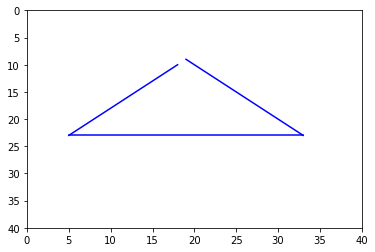

In [156]:
# plota os pontos e a curva de ajuste
plt.xlim(0, img.shape[0])
plt.ylim(0, img.shape[1])

#plt.plot(segmento1y, segmento1x, 'o', label="Data",markersize=1)            # plota os pontos das bordas
plt.plot( segmento1y, f_seg_1(segmento1y), 'b-', label="Polyfit")            # plota o ajuste

#plt.plot(segmento2y, segmento2x, 'o', label="Data",markersize=3)            # plota os pontos das bordas
plt.plot(segmento2y,f(segmento2y), 'b-', label="Polyfit")            # plota o ajuste

#plt.plot(segmento3y, segmento3x, 'o', label="Data",markersize=5)            # plota os pontos das bordas
plt.plot( segmento3y,f_seg_3(segmento3y),  'b-', label="Polyfit")           # plota o ajuste

plt.gca().invert_yaxis()

Text(0.5, 1.0, 'Versao Vetorizada')

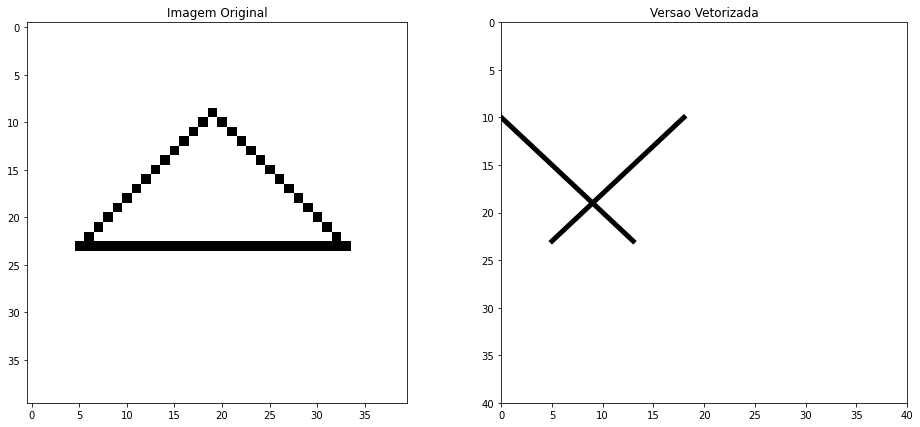

In [22]:
# a versao vetorizada ficaria assim: 

plt.figure(1, figsize=(16,7))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1,2,2)
plt.xlim(0, img.shape[0])
plt.ylim(0, img.shape[1]) 
plt.plot(f_seg_1(segmento1x), segmento1x,  'b-', color='black',  linewidth=5)
plt.plot(f_seg_2(segmento2x), segmento2x,  'b-', color='black',  linewidth=5)
plt.plot(f_seg_3(segmento3x), segmento3x,  'b-', color='black',  linewidth=5)
plt.gca().invert_yaxis()
plt.title('Versao Vetorizada')

Alguns links que podem ajudar
http://www.imageprocessingplace.com/downloads_V3/root_downloads/tutorials/contour_tracing_Abeer_George_Ghuneim/moore.html
https://www.reddit.com/r/Python/comments/f2kv1/question_on_tracing_an_image_in_python_with_pil/
https://stackoverflow.com/questions/9137216/python-edge-detection-and-curvature-calculation
https://www.scan2cad.com/dxf/convert/algorithms-raster-to-vector-conversion/
https://medium.com/data-breach/introduction-to-harris-corner-detector-32a88850b3f6

In [23]:
# teste margem de fit

img_test = np.array([[  2., 2., 2., 2., 2., 2., 2., 2.],
                       [2., 1., 2., 2., 2., 2., 2., 2.],
                       [2., 2., 1., 2., 2., 2., 1., 2.],
                       [2., 2., 1., 1., 2., 1., 2., 2.],
                       [2., 2., 2., 1., 1., 2., 2., 2.],
                       [2., 2., 2., 2., 2., 2., 2., 2.],
                       [2., 2., 2., 2., 2., 2., 2., 2.],
                       [2., 2., 2., 2., 2., 2., 2., 2.]])

In [24]:
pointsX = [2, 3, 3]
pointsY = [2, 3, 4]
newPointX, newPointY = [4, 4]
fit_now = np.polyfit(pointsX, pointsY, 1) 
f_now = np.poly1d(fit_now)


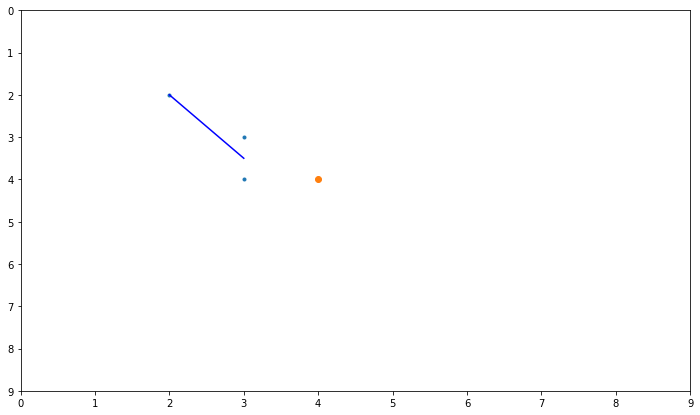

In [25]:
plt.figure(1, figsize=(12,7))
plt.xlim(0, 9)
plt.ylim(0, 9) 
plt.plot(pointsX, pointsY, 'o', label="Data", markersize=3)            # plota os pontos das bordas
plt.plot(4, 4, 'o')
plt.plot(pointsX, f_now(pointsX),  'b-', label="Polyfit")           # plota o ajuste
plt.gca().invert_yaxis()

In [26]:
# calcula o erro quadratico entre a projeção do fit para o X 
# do proximo ponto e seu valor real em Y
#  (Py - fit[Px])²
np.power(newPointY - f_now(newPointX), 2)

1.0

In [27]:
startX, startY = [2,2]
for(x)

SyntaxError: invalid syntax (<ipython-input-27-22dbcbf9bb0f>, line 2)